### RECOMMENDATION SYS

In [3]:
import os

# ساخت پوشه ها
os.makedirs("/kaggle/working/models", exist_ok=True)
os.makedirs("/kaggle/working/reports", exist_ok=True)

### Load datasets from Kaggle input directory

In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    movies_df = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
    credits_df = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')
    keywords_df = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv')
    ratings_df = pd.read_csv('/kaggle/input/the-movies-dataset/ratings.csv')
    print("All datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files are in the specified directory.")

/tmp/ipykernel_79/1424678245.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')


All datasets loaded successfully!


### Data Cleaning and Joining

In [5]:

# The 'id' column in movies_df is not always a valid number. We need to handle this.
# Let's count the number of rows dropped to quantify information loss.
initial_rows = movies_df.shape[0]
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
movies_df = movies_df.dropna(subset=['id'])
movies_df['id'] = movies_df['id'].astype(int)
rows_dropped_id = initial_rows - movies_df.shape[0]

print(f"Initial rows in movies_df: {initial_rows}")
print(f"Rows dropped due to invalid 'id': {rows_dropped_id}")

# Merge credits and keywords dataframes on the 'id' column.
movies_df = pd.merge(movies_df, credits_df, on='id', how='left')
movies_df = pd.merge(movies_df, keywords_df, on='id', how='left')

# Function to safely parse JSON strings and extract 'name' values
def parse_json_to_list(json_string):
    if pd.isna(json_string) or json_string == '':
        return []
    try:
        data = json.loads(json_string.replace("'", '"'))
        return [item['name'] for item in data]
    except (json.JSONDecodeError, TypeError):
        return []

# Columns that contain JSON-like strings
json_cols_to_parse = ['genres', 'keywords', 'cast', 'crew']

for col in json_cols_to_parse:
    movies_df[col] = movies_df[col].apply(parse_json_to_list)

print(f"Total rows after joining: {movies_df.shape[0]}")
print(f"A sample of parsed genres: {movies_df['genres'].head().values}")

Initial rows in movies_df: 45466
Rows dropped due to invalid 'id': 3
Total rows after joining: 46629
A sample of parsed genres: [list(['Animation', 'Comedy', 'Family'])
 list(['Adventure', 'Fantasy', 'Family']) list(['Romance', 'Comedy'])
 list(['Comedy', 'Drama', 'Romance']) list(['Comedy'])]


### Exploratory Data Analysis (EDA)


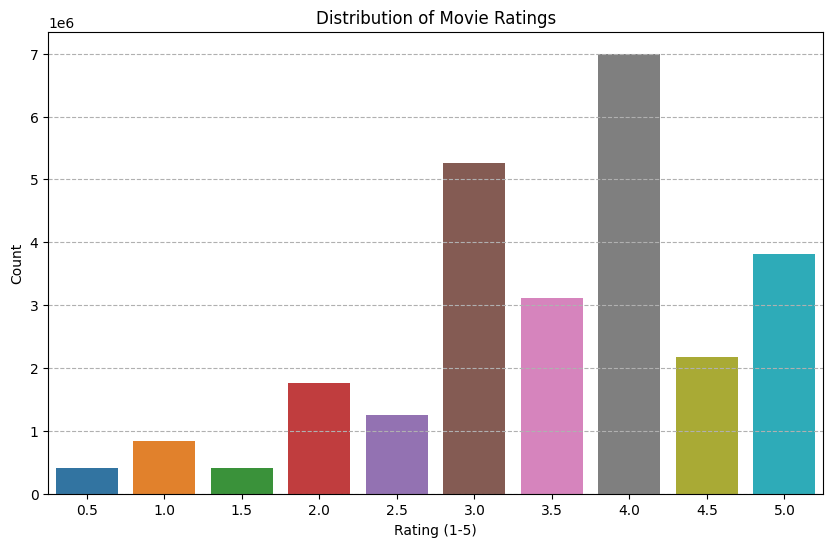

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


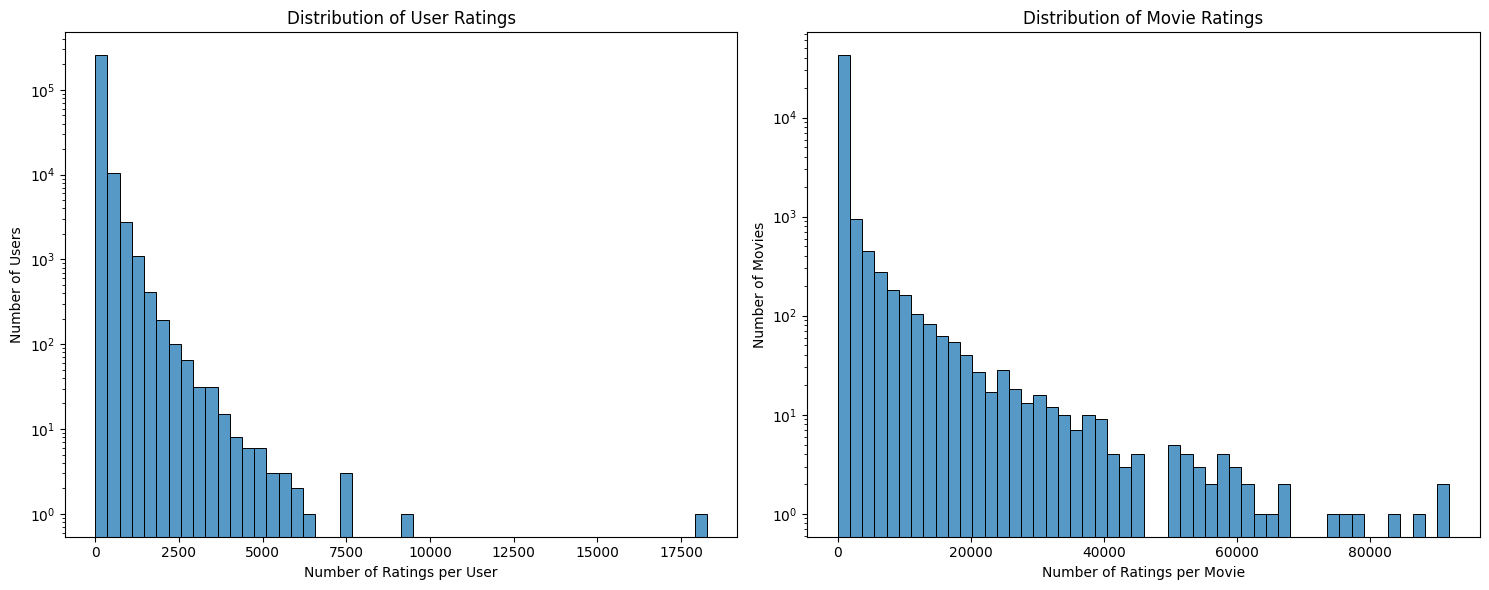

Total number of unique users: 270896
Total number of unique movies with ratings: 45115
Total number of ratings: 26024289
Sparsity of the rating matrix: 99.79%


In [6]:

# 1. Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--')
plt.savefig('/kaggle/working/reports/ratings_distribution.png')
plt.show()


# 2. Long-tail of Users and Movies
user_counts = ratings_df['userId'].value_counts()
movie_counts = ratings_df['movieId'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(user_counts, bins=50, ax=axes[0])
axes[0].set_title('Distribution of User Ratings')
axes[0].set_xlabel('Number of Ratings per User')
axes[0].set_ylabel('Number of Users')
axes[0].set_yscale('log') # Use log scale to better visualize the long tail

sns.histplot(movie_counts, bins=50, ax=axes[1])
axes[1].set_title('Distribution of Movie Ratings')
axes[1].set_xlabel('Number of Ratings per Movie')
axes[1].set_ylabel('Number of Movies')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# 3. Sparsity of the rating matrix
num_users = ratings_df['userId'].nunique()
num_movies_rated = ratings_df['movieId'].nunique()
num_ratings = ratings_df.shape[0]
sparsity = 1 - (num_ratings / (num_users * num_movies_rated))

print(f"Total number of unique users: {num_users}")
print(f"Total number of unique movies with ratings: {num_movies_rated}")
print(f"Total number of ratings: {num_ratings}")
print(f"Sparsity of the rating matrix: {sparsity:.2%}")

### Additional EDA genres & Language

Top 10 Genres:
              Genre  Count
6             Drama  20809
1            Comedy  13467
9          Thriller   7794
5           Romance   6923
7            Action   6730
10           Horror   4762
8             Crime   4387
17      Documentary   4050
3         Adventure   3587
12  Science Fiction   3140


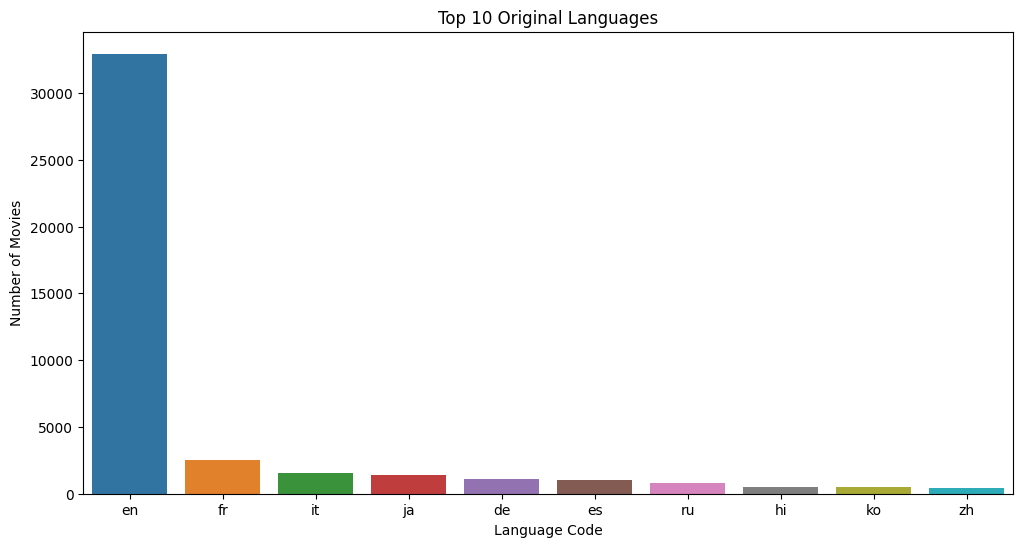

In [7]:

# Function to get all unique genres and their counts
def get_item_counts(list_series):
    counts = {}
    for sublist in list_series:
        for item in sublist:
            counts[item] = counts.get(item, 0) + 1
    return counts

# 1. Genre Coverage
genre_counts = get_item_counts(movies_df['genres'])
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values('Count', ascending=False)
print("Top 10 Genres:")
print(genre_df.head(10))

# 2. Language Coverage
language_counts = movies_df['original_language'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=language_counts.index, y=language_counts.values)
plt.title('Top 10 Original Languages')
plt.xlabel('Language Code')
plt.ylabel('Number of Movies')
plt.show()

### Task 2: Baselines

In [8]:
# C: Global Mean Rating
C = movies_df['vote_average'].mean()
print(f"Global mean rating (C): {C:.2f}")

# m: Minimum Vote Threshold
# The project suggests using the 80th percentile of the vote counts.
m = movies_df['vote_count'].quantile(0.80)
print(f"Minimum required votes (m): {m:.2f}")

Global mean rating (C): 5.61
Minimum required votes (m): 49.00


In [9]:
def weighted_rating(x, m, C):
    """
    Calculates the IMDb weighted rating.
    
    Args:
        x (pd.Series): A row from the DataFrame.
        m (float): Minimum vote threshold.
        C (float): Global mean rating.
        
    Returns:
        float: The calculated score.
    """
    v = x['vote_count']
    R = x['vote_average']
    
    return (v / (v + m)) * R + (m / (v + m)) * C

# Filter movies that have at least the minimum required votes (m).
qualified_movies = movies_df.copy().loc[movies_df['vote_count'] >= m]
print(f"\nNumber of qualified movies: {qualified_movies.shape[0]}")

# Apply the weighted rating function to calculate the score for each movie.
qualified_movies['score'] = qualified_movies.apply(weighted_rating, args=(m, C), axis=1)

# Sort the movies by their score in descending order.
top_rated_movies = qualified_movies.sort_values('score', ascending=False)

# Display the top 10 movies
print("\nTop 10 movies based on IMDb formula:")
print(top_rated_movies[['title', 'vote_count', 'vote_average', 'score']].head(10))


Number of qualified movies: 9422

Top 10 movies based on IMDb formula:
                             title  vote_count  vote_average     score
10357  Dilwale Dulhania Le Jayenge       661.0           9.1  8.859252
314       The Shawshank Redemption      8358.0           8.5  8.483165
837                  The Godfather      6024.0           8.5  8.476695
41402                   Your Name.      1030.0           8.5  8.368831
12541              The Dark Knight     12269.0           8.3  8.289306
2858                    Fight Club      9678.0           8.3  8.286457
292                   Pulp Fiction      8670.0           8.3  8.284891
522               Schindler's List      4436.0           8.3  8.270628
23818                     Whiplash      4376.0           8.3  8.270230
5505                 Spirited Away      3968.0           8.3  8.267207


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


### Task 3: Content-Base model

In [10]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Assume movies_df is already loaded and merged from previous steps in your notebook
# You can see this from your notebook output.
# movies_df = pd.merge(movies_df, credits_df, on='id', how='left')
# movies_df = pd.merge(movies_df, keywords_df, on='id', how='left')
#
# Your code already has a helper function to parse JSON-like strings:
# def parse_json_to_list(json_string):
#    ...
# And you've already applied it to the relevant columns:
# movies_df[col] = movies_df[col].apply(parse_json_to_list)

# Now let's define the new helper functions required for the next steps
def get_top_k(names, k=3):
    """
    Extracts the first 'k' names from a list.
    """
    return names[:k] if isinstance(names, list) else []

def clean_names(names):
    """
    Converts names to lowercase and removes spaces for consistency.
    """
    if isinstance(names, list):
        return [str.lower(s.replace(" ", "")) for s in names]
    return []

# Apply the functions to create the 'top_cast' and 'top_crew' columns
movies_df['top_cast'] = movies_df['cast'].apply(get_top_k).apply(clean_names)
movies_df['top_crew'] = movies_df['crew'].apply(get_top_k).apply(clean_names)

# Clean the other relevant columns
movies_df['genres'] = movies_df['genres'].apply(clean_names)
movies_df['keywords'] = movies_df['keywords'].apply(clean_names)

# Create a 'soup' of all features for each movie
def create_soup(x):
    """
    Combines all cleaned features into a single string.
    """
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['top_cast']) + ' ' + ' '.join(x['top_crew']) + ' ' + ' '.join(x['genres'])

# Apply the create_soup function to create the 'soup' column
# We use movies_df instead of df to match your notebook
movies_df['soup'] = movies_df.apply(create_soup, axis=1)

print("Data preparation for content-based model is complete.")
print(f"Number of movies: {movies_df.shape[0]}")
print("A sample 'soup' of a movie:")
print(movies_df['soup'].sample(1).values[0])

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['soup'].fillna(''))

print(f"\nShape of TF-IDF matrix: {tfidf_matrix.shape}")

# Calculate Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"Shape of Cosine Similarity matrix: {cosine_sim.shape}")

# Create a mapping from movie title to index for easy lookup later
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

print("\nMovie feature vectors and similarity matrix created successfully.")

Data preparation for content-based model is complete.
Number of movies: 46629
A sample 'soup' of a movie:
ambush sanfrancisco detective ransom stadium sniper mayor kidnapping nudity chase investigation assault police psychopath swimmingpool partner beating serialkiller gunfight maniac violence city schoolbus dirtyharry elephonebox revolver neo-noir   action crime thriller

Shape of TF-IDF matrix: (46629, 33646)
Shape of Cosine Similarity matrix: (46629, 46629)

Movie feature vectors and similarity matrix created successfully.


In [12]:
# Assuming you have the ratings_df loaded from Task 1 and the tfidf_matrix from Task 3
# and also the movies_df that includes 'tmdbId' and 'title'.

def build_user_profile(user_id, ratings_df, movies_df, tfidf_matrix, indices):
    """
    Builds a user profile vector based on their rated movies.
    
    Args:
        user_id (int): The ID of the user.
        ratings_df (pd.DataFrame): DataFrame with user ratings.
        movies_df (pd.DataFrame): DataFrame with movie data.
        tfidf_matrix: The TF-IDF matrix of movie features.
        indices (pd.Series): Mapping from movie titles to indices.
        
    Returns:
        numpy.array: The user profile vector.
    """
    # Filter for the user's ratings
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    # Merge ratings with movie data to get tmdbId
    rated_movies_with_info = pd.merge(user_ratings, movies_df[['tmdbId', 'title']], 
                                      left_on='tmdbId', right_on='tmdbId', how='inner')
    
    # Get the indices of the movies the user has rated
    movie_indices = [indices.get(title) for title in rated_movies_with_info['title'] if title in indices]
    
    # Get the TF-IDF vectors for those movies
    rated_movie_vectors = tfidf_matrix[movie_indices]
    
    # Get the ratings given by the user, normalized
    ratings = rated_movies_with_info['rating'].values
    
    # Calculate the weighted average of the movie vectors
    user_profile = np.average(rated_movie_vectors.toarray(), axis=0, weights=ratings)
    
    return user_profile

In [14]:
def get_content_based_recommendations(user_profile, movies_df, tfidf_matrix, cosine_sim, indices, ratings_df, user_id, k=10):
    """
    Generates content-based movie recommendations for a user.
    
    Args:
        user_profile (numpy.array): The user's profile vector.
        movies_df (pd.DataFrame): DataFrame with movie data.
        tfidf_matrix: The TF-IDF matrix of movie features.
        cosine_sim: Cosine similarity matrix.
        indices (pd.Series): Mapping from movie titles to indices.
        ratings_df (pd.DataFrame): DataFrame with user ratings.
        user_id (int): The ID of the user.
        k (int): Number of recommendations to return.
        
    Returns:
        pd.DataFrame: A DataFrame with the top 'k' recommended movies.
    """
    # Get cosine similarities between the user profile and all movie vectors
    movie_scores = cosine_similarity(user_profile.reshape(1, -1), tfidf_matrix).flatten()
    
    # Get the indices of the movies sorted by similarity score
    sorted_movie_indices = movie_scores.argsort()[::-1]
    
    # Get the movies the user has already seen
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    seen_movies_tmdb_ids = user_ratings['tmdbId'].values
    
    recommendations = []
    for idx in sorted_movie_indices:
        movie_tmdb_id = movies_df.iloc[idx]['tmdbId']
        # Exclude movies the user has already seen
        if movie_tmdb_id not in seen_movies_tmdb_ids:
            recommendations.append({
                'title': movies_df.iloc[idx]['title'],
                'score': movie_scores[idx],
                'genres': movies_df.iloc[idx]['genres']
            })
            if len(recommendations) >= k:
                break
    
    return pd.DataFrame(recommendations)

# Example Usage:
# Assume user 1 has ratings in the ratings_df
# user_profile_1 = build_user_profile(1, ratings_df, movies_df, tfidf_matrix, indices)
# recommendations_for_user_1 = get_content_based_recommendations(user_profile_1, movies_df, tfidf_matrix, cosine_sim, indices, ratings_df, 1)
# print(recommendations_for_user_1)

In [15]:
def get_cold_start_recommendations(movies_df, m, C, k=10):
    """
    Provides popularity-based recommendations for new users.
    """
    qualified_movies = movies_df.copy().loc[movies_df['vote_count'] >= m]
    qualified_movies['score'] = (qualified_movies['vote_count'] / (qualified_movies['vote_count'] + m)) * qualified_movies['vote_average'] + (m / (qualified_movies['vote_count'] + m)) * C
    return qualified_movies.sort_values('score', ascending=False)[['title', 'score']].head(k)

In [16]:
def get_recommendation_explanation(user_id, recommended_movie_title, ratings_df, movies_df, k=3):
    """
    Generates a natural-language explanation for a recommendation.
    """
    # Get the user's top-rated movies
    user_top_rated = ratings_df[ratings_df['userId'] == user_id].sort_values('rating', ascending=False).head(k)
    user_top_rated_titles = movies_df[movies_df['tmdbId'].isin(user_top_rated['tmdbId'])]['title'].values
    
    recommended_movie = movies_df[movies_df['title'] == recommended_movie_title].iloc[0]
    
    explanations = []
    
    # Iterate through the user's top-rated movies to find common features
    for movie_title in user_top_rated_titles:
        if movie_title == recommended_movie_title:
            continue
            
        rated_movie = movies_df[movies_df['title'] == movie_title].iloc[0]
        
        common_genres = set(rated_movie['genres']).intersection(set(recommended_movie['genres']))
        common_cast = set(rated_movie['top_cast']).intersection(set(recommended_movie['top_cast']))
        common_keywords = set(rated_movie['keywords']).intersection(set(recommended_movie['keywords']))
        
        if common_genres:
            explanations.append(f" because it shares genres like {', '.join(common_genres)} with movies you liked, such as '{movie_title}'.")
        if common_cast:
            explanations.append(f" because it stars {', '.join(common_cast)} who also appeared in '{movie_title}'.")
        if common_keywords:
            explanations.append(f" because it is about {', '.join(common_keywords)} just like '{movie_title}'.")
    
    if explanations:
        return f"We recommend '{recommended_movie_title}'" + ' '.join(explanations)
    else:
        return f"We recommend '{recommended_movie_title}' because it is similar to other movies you have liked."

In [17]:
# فرض می‌کنیم دیتافریم‌ها و ماتریس‌ها از مراحل قبلی در دسترس هستند:
# movies_df
# ratings_df
# tfidf_matrix
# cosine_sim
# indices
# m (from Task 2)
# C (from Task 2)

def recommend_movie_cb_final(user_id, ratings_df, movies_df, tfidf_matrix, cosine_sim, indices, m, C, k=10):
    """
    Provides comprehensive content-based recommendations for a user.
    Handles cold-start users and provides explanations for recommendations.
    
    Args:
        user_id (int): The ID of the user.
        ... other necessary dataframes and objects ...
        k (int): Number of recommendations to return.
        
    Returns:
        A DataFrame with recommendations and a list of explanations.
    """
    
    # Check if the user is a cold-start user (no ratings in the dataset)
    if user_id not in ratings_df['userId'].unique():
        print(f"کاربر با شناسه {user_id} جدید است. پیشنهادها بر اساس محبوبیت جهانی ارائه می‌شوند.")
        recommendations = get_cold_start_recommendations(movies_df, m, C, k)
        explanations = [f"این فیلم‌ها به دلیل محبوبیت بالا در سراسر جهان به شما پیشنهاد می‌شوند."] * len(recommendations)
        return recommendations, explanations
    
    # If the user has a rating history, build their profile and get content-based recommendations
    print(f"ساخت پروفایل برای کاربر با شناسه {user_id}...")
    user_profile = build_user_profile(user_id, ratings_df, movies_df, tfidf_matrix, indices)
    
    print("در حال پیدا کردن بهترین پیشنهادها...")
    recommendations = get_content_based_recommendations(user_profile, movies_df, tfidf_matrix, cosine_sim, indices, ratings_df, user_id, k)
    
    print("تولید توضیحات برای پیشنهادها...")
    explanations = []
    for title in recommendations['title']:
        explanation = get_recommendation_explanation(user_id, title, ratings_df, movies_df)
        explanations.append(explanation)
        
    return recommendations, explanations

# --- نحوه استفاده از تابع نهایی ---
# فرض کنید کاربر 1000 در دیتافریم شما وجود دارد (کاربر با سابقه)
# recommendations_for_user_1000, explanations_for_user_1000 = recommend_movie_cb_final(1000, ratings_df, movies_df, tfidf_matrix, cosine_sim, indices, m, C)
# print("پیشنهادهای برای کاربر با سابقه:")
# print(recommendations_for_user_1000)
# print("\nتوضیحات:")
# for exp in explanations_for_user_1000:
#     print(f"- {exp}")

# --- نحوه استفاده برای یک کاربر جدید (مثلا کاربر 999999)
# recommendations_for_new_user, explanations_for_new_user = recommend_movie_cb_final(999999, ratings_df, movies_df, tfidf_matrix, cosine_sim, indices, m, C)
# print("\nپیشنهادهای برای کاربر جدید:")
# print(recommendations_for_new_user)
# print("\nتوضیحات:")
# for exp in explanations_for_new_user:
#     print(f"- {exp}")

In [18]:
import pickle
import numpy as np

# ذخیره ماتریس شباهت کسینوسی
np.save('/kaggle/working/models/cosine_sim_matrix.npy', cosine_sim)
print("ماتریس شباهت کسینوسی در پوشه models ذخیره شد.")

ماتریس شباهت کسینوسی در پوشه models ذخیره شد.


### Collaborative Filtering

In [1]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans, SVD
from surprise import accuracy
import pickle
import os

# فرض بر این است که دیتافریم ratings_df قبلاً بارگذاری شده است
# و پوشه‌های models و reports ایجاد شده‌اند.

# بارگذاری داده‌ها با کتابخانه Surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

print("داده‌ها بارگذاری و به دو مجموعه آموزشی و تست تقسیم شدند.")

# --- بخش اول: مدل مبتنی بر همسایگی (Neighborhood-based) ---
# پیاده‌سازی فیلترینگ مشارکتی مبتنی بر آیتم (Item-based)
sim_options = {
    'name': 'cosine',
    'user_based': False  # محاسبه شباهت بین آیتم‌ها
}
knn_model = KNNWithMeans(sim_options=sim_options)

# آموزش مدل KNN با میانگین
print("\nدر حال آموزش مدل مبتنی بر همسایگی (KNNWithMeans)...")
knn_model.fit(trainset)

# پیش‌بینی روی مجموعه تست
knn_predictions = knn_model.test(testset)

# ارزیابی عملکرد مدل
print("\nنتایج مدل KNN با میانگین:")
accuracy.rmse(knn_predictions)

# ذخیره مدل KNN با استفاده از pickle
with open('/kaggle/working/models/knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)
print("مدل KNN با میانگین در پوشه models ذخیره شد.")

# --- بخش دوم: مدل فاکتورسازی ماتریسی (Matrix Factorization) ---
# پیاده‌سازی SVD
svd_model = SVD(random_state=42)

# آموزش مدل SVD
print("\nدر حال آموزش مدل فاکتورسازی ماتریسی (SVD)...")
svd_model.fit(trainset)

# پیش‌بینی روی مجموعه تست
svd_predictions = svd_model.test(testset)

# ارزیابی عملکرد مدل
print("\nنتایج مدل SVD:")
accuracy.rmse(svd_predictions)

# ذخیره مدل SVD
with open('/kaggle/working/models/svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)
print("مدل SVD در پوشه models ذخیره شد.")

NameError: name 'ratings_df' is not defined